## Imports & Variables

In [82]:
#Imports

import os
import time
import joblib
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso

#Ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

#Other models
from sklearn.neighbors import KNeighborsRegressor

#Sklearn
from sklearn.datasets import _california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

#Settings
plt.style.use('dark_background')

In [83]:
#Variables

#Creation du dataframe avec le dataset
dataset = _california_housing.fetch_california_housing(as_frame=True)
df = dataset.frame

#Definition de la target
target_name = "MedHouseVal"
target = df[target_name]

#Colonnes exclues pour le test
columns_to_drop = [
    target_name, 
    # "Population", 
    # "AveOccup", 
    # "AveBedrms", 
    # "HouseAge", 
    # "AveRooms"
]
data = df.drop(columns=columns_to_drop)


data, target = _california_housing.fetch_california_housing(as_frame=True, return_X_y=True)
#Split
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=69)

#Modèles à tester
linear_models = [
    LinearRegression(),
    Ridge(random_state=69),
    RidgeCV(),
    Lasso(random_state=69),
]

ens_models = [
    AdaBoostRegressor(random_state=69),  
    BaggingRegressor(random_state=69, n_jobs=-1), 
    ExtraTreesRegressor(random_state=69, n_jobs=-1), 
    GradientBoostingRegressor(random_state=69), 
    RandomForestRegressor(random_state=69, n_jobs=-1), 
    HistGradientBoostingRegressor(random_state=69)
]

boost_and_bag_models = [
    AdaBoostRegressor(base_estimator=BaggingRegressor(random_state=69, n_jobs=-1)),
    AdaBoostRegressor(base_estimator=ExtraTreesRegressor(random_state=69, n_jobs=-1)),
    AdaBoostRegressor(base_estimator=GradientBoostingRegressor(random_state=69)),
    AdaBoostRegressor(base_estimator=RandomForestRegressor(random_state=69, n_jobs=-1)),
    AdaBoostRegressor(base_estimator=HistGradientBoostingRegressor(random_state=69)),

    BaggingRegressor(base_estimator=BaggingRegressor(random_state=69, n_jobs=-1)),
    BaggingRegressor(base_estimator=ExtraTreesRegressor(random_state=69, n_jobs=-1)),
    BaggingRegressor(base_estimator=GradientBoostingRegressor(random_state=69)),
    BaggingRegressor(base_estimator=RandomForestRegressor(random_state=69, n_jobs=-1)),
    BaggingRegressor(base_estimator=HistGradientBoostingRegressor(random_state=69)),
]

# AdaBoostRegressor(random_state=69, learning_rate=1,n_estimators=115, base_estimator=HistGradientBoostingRegressor(random_state=69, learning_rate=0.1, max_iter=1000, max_depth=7, warm_start=True, max_leaf_nodes=None))

## I - Début de l'analyse des données

In [84]:
#Infos du dataset

print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

<AxesSubplot: >

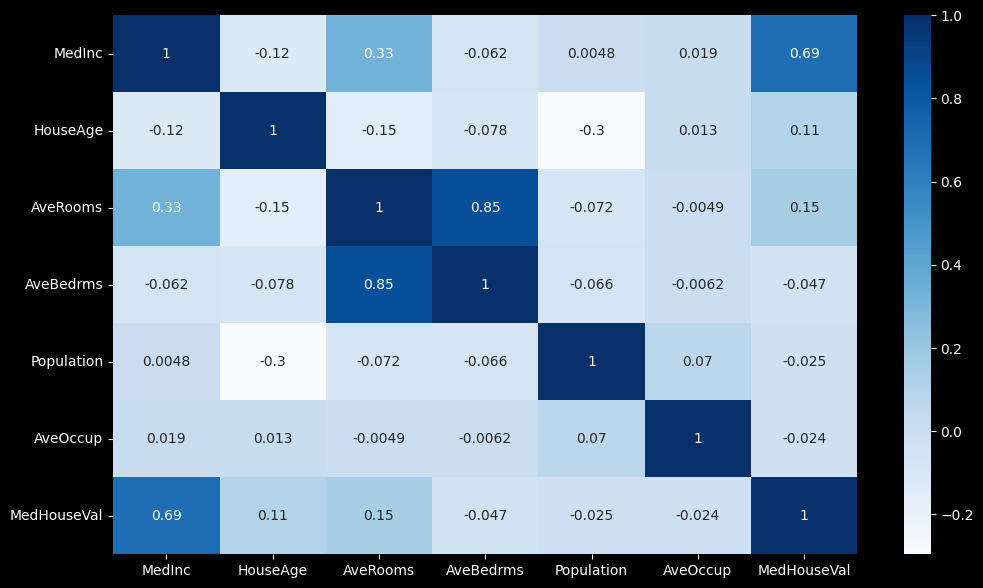

In [85]:
#Heatmap

data_heatmap = df.drop(columns=["Latitude", "Longitude"])
plt.figure(figsize=(12,7))
sns.heatmap(data_heatmap.corr(),cbar=True,annot=True,cmap='Blues')

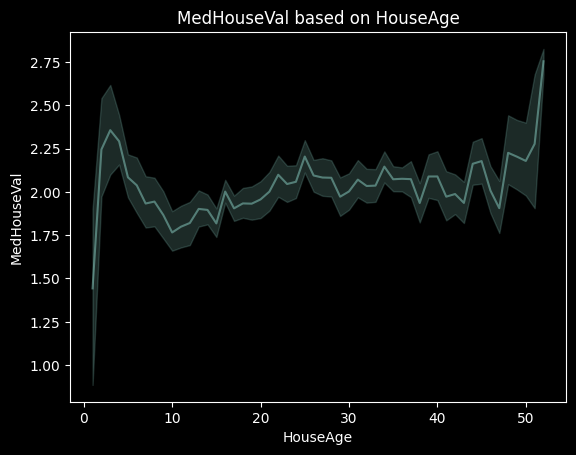

In [86]:
#Prix moyen en fonction de l'age des maisons

sns.lineplot(df,
                x="HouseAge", y="MedHouseVal", alpha=0.5)
plt.title("MedHouseVal based on HouseAge")

plt.show()

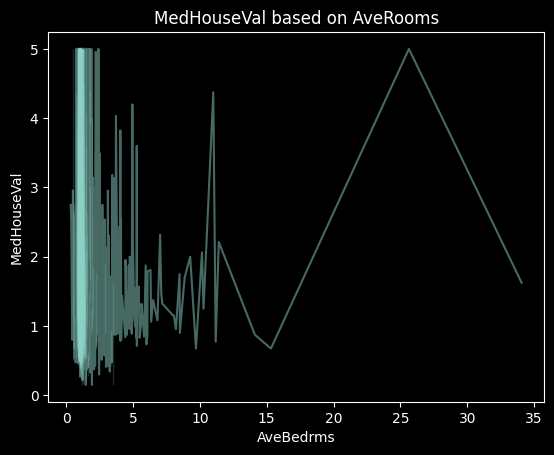

In [87]:
#Prix moyen en fonction du nombre de pièces

sns.lineplot(df,
                x="AveBedrms", y="MedHouseVal", alpha=0.5)
plt.title("MedHouseVal based on AveRooms")

plt.show()

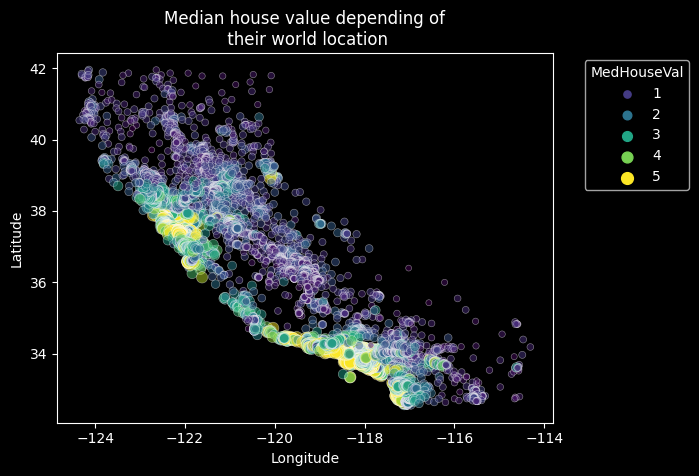

In [88]:
#Prix moyen en fonction de la localisation géographique

sns.scatterplot(df,
                x="Longitude", y="Latitude",
                size="MedHouseVal", hue="MedHouseVal",
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 1),
           loc="upper left")
plt.title("Median house value depending of\n their world location")

plt.show()

## II - Recherche du modèle adéquat

### 1) Premiers essais

In [89]:
#RandomForestClassifier

modele_rf = RandomForestClassifier(
    # il s’agit du nombre d’arbres dans la forêt
    n_estimators=5,
    # il s’agit du critère utilisé pour construire les arbres et séparer les branches des arbres
    criterion='gini',
    # il s’agit de la profondeur maximale des arbres utilisés (le nombre de niveaux dans l’arbre de décision)
    max_depth=None,
    # il s’agit du nombre d’échantillons minimal dans une feuille pour refaire une séparation
    min_samples_split=2,
    # il s’agit du nombre d’échantillons minimal pour créer une feuille
    min_samples_leaf=1,
    # il s’agit de la fraction du nombre total d’échantillon minimal pour créer une feuille
    min_weight_fraction_leaf=0.0,
    # il s’agit du nombre maximal de feuilles
    max_leaf_nodes=None,
    # il s’agit de la baisse minimale du critère d’impureté pour faire une séparation
    min_impurity_decrease=0.0,
    # paramètre pour utiliser du bootstrap, si il est à False, le même échantillon est pris pour chaque arbre
    bootstrap=True,
    # ??
    oob_score=False,
    # nombre de traitements à effectuer en parallèle
    n_jobs=None,
    # graine aléatoire
    random_state=None,
    # ??
    verbose=0,
    # ceci permet de repartir du résultat du dernier apprentissage pour faire l’apprentissage
    warm_start=False,
    # il s’agit des poids associés à chaque classe si cela a un sens
    class_weight=None,
    # ??
    ccp_alpha=0.0,
    # si vous voulez réduire le nombre d’observations dans vos échantillons bootstrap
    max_samples=None,
)

#modele_rf.fit(data, target)

In [90]:
#KNeighborsRegressor

#Colonnes exclues pour le train
KNeighborsRegressor_data = df.drop(columns=[target_name, "AveOccup", "Population", "HouseAge", "AveBedrms" , "AveRooms"])

#Entrainement
KNeighborsRegressor_model = KNeighborsRegressor()
KNeighborsRegressor_model.fit(KNeighborsRegressor_data, target)

target_predicted = KNeighborsRegressor_model.predict(KNeighborsRegressor_data)
print(target[:5])
print(target_predicted[:5])
print(f"Number of correct prediction: "
      f"{(target[:5] == target_predicted[:5]).sum()} / 5")

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64
[3.967  3.7268 3.626  3.436  2.4272]
Number of correct prediction: 0 / 5


### 2) Modèles linéaires

In [91]:
#Test de tous les modèles linéaires

#Nombre de tests par modèle
attemps = 200

def TestLinearModels(models):
    
    #Initialisation de la dataframe des resultats
    result_df = pd.DataFrame(columns=["ModelName","AvgScore","MaxScore","AvgExecTime"])

    for model in models:

        #Affichage
        model_name = model.__class__.__name__
        print(f"{model_name}")

        #Initialisation des listes
        score_results = []
        time_results = []
        
        for i in tqdm(range(attemps)):

            #Demarrage du timer
            start = time.time()

            #Fit
            model.fit(data_train, target_train)

            #Calcul du score
            score = model.score(data_test, target_test)

            #Sauvegarde des resultats dans les listes
            score_results.append(score)
            time_results.append(time.time() - start)

        #Calcul des stats
        avg_score = round(np.average(score_results) * 100, 3)
        max_score = round(np.max(score_results) * 100, 3)
        avg_time = round(np.average(time_results), 3)

        #Sauvegarde des resultats dans la dataframe
        new_row = pd.DataFrame([[model_name, avg_score, max_score, avg_time]], columns=["ModelName","AvgScore","MaxScore","AvgExecTime"])
        result_df = pd.concat([result_df, new_row])

    #Affichage
    print(f"-"*49, "\nResults :")
    print(result_df.to_string(index=False))
    print(f"-"*49)

#Call de la fonction
TestLinearModels(linear_models)

LinearRegression


100%|██████████| 200/200 [00:00<00:00, 208.13it/s]


Ridge


100%|██████████| 200/200 [00:00<00:00, 438.59it/s]


RidgeCV


100%|██████████| 200/200 [00:01<00:00, 148.63it/s]


Lasso


100%|██████████| 200/200 [00:00<00:00, 204.42it/s]

------------------------------------------------- 
Results :
       ModelName  AvgScore  MaxScore  AvgExecTime
LinearRegression    60.605    60.605        0.005
           Ridge    60.605    60.605        0.002
         RidgeCV    60.610    60.610        0.007
           Lasso    28.506    28.506        0.005
-------------------------------------------------


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


<Figure size 640x480 with 0 Axes>

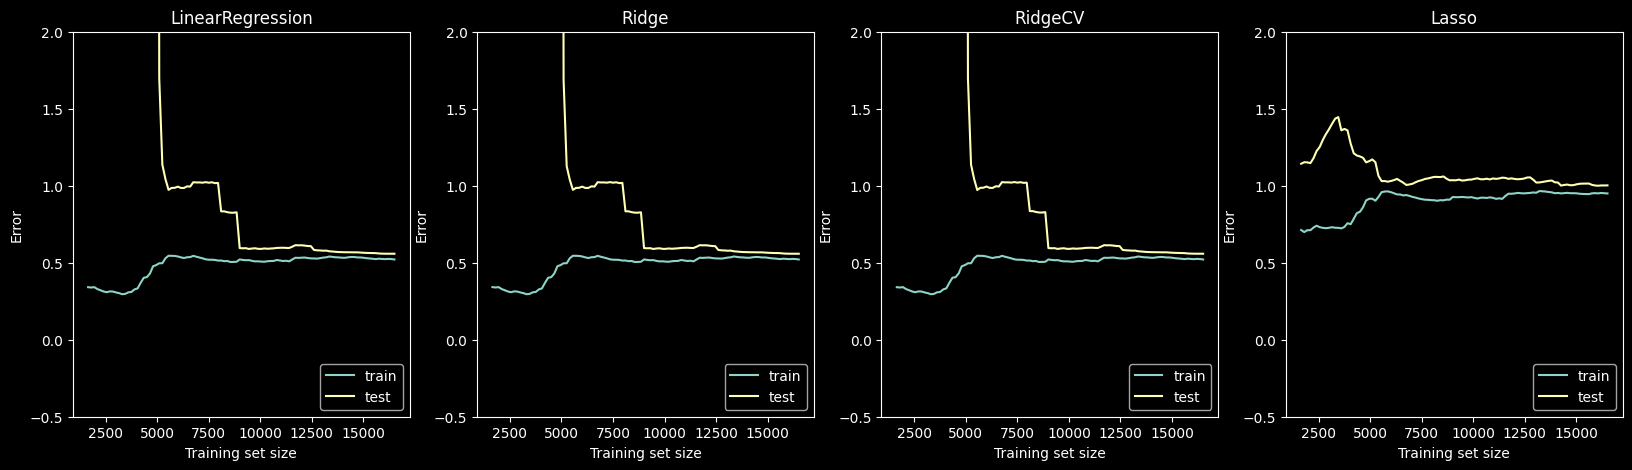

In [92]:
#Learning curves des modèles linéaires

def linear_learnings_curves(
    models,
    data,
    target
):
    plt.figure(1)
    fig, graphs = plt.subplots(1, len(models), figsize=(5* len(models), 5))
    n_jobs = -1
    points_amount = 100
    train_score_arr = []
    test_scores_arr = []

    for i in tqdm(range(len(models))):
        graphs[i].set_title(models[i].__class__.__name__)
        graphs[i].set_xlabel("Training set size")
        graphs[i].set_ylabel("Error")
        
        train_sizes, train_scores, test_scores = learning_curve(
        random_state=69,
        estimator = models[i],
        X=data,
        y=target,
        n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1, points_amount),
        scoring="neg_mean_squared_error"
        )

        train_scores_mean = -np.mean(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)

        train_score_arr.append(train_scores_mean)
        test_scores_arr.append(test_scores_mean)

    for i in range(len(train_score_arr)):
        graphs[i].set_ylim(-0.5,2)
        graphs[i].plot(train_sizes, train_score_arr[i])
        graphs[i].plot(train_sizes, test_scores_arr[i])
        graphs[i].legend(labels=["train", "test"], loc="lower right")

    return plt


#Call de la fonction
linear_learnings_curves(
    linear_models,
    data,
    target
)

plt.show()

### 3) Ensembles

In [93]:
#Test de tous les modèles ensemblistes

#Nombre de tests par modèle
attemps = 10

def TestEnsModels(models):
    
    #Initialisation de la dataframe des resultats
    result_df = pd.DataFrame(columns=["ModelName","AvgScore","MaxScore","AvgExecTime"])

    for model in models:

        #Affichage
        model_name = model.__class__.__name__
        print(f"{model_name}")

        #Initialisation des listes
        score_results = []
        time_results = []
        
        for i in tqdm(range(attemps)):

            #Demarrage du timer
            start = time.time()

            #Fit
            model.fit(data_train, target_train)

            #Calcul du score
            score = model.score(data_test, target_test)

            #Sauvegarde des resultats dans les listes
            score_results.append(score)
            time_results.append(time.time() - start)

        #Calcul des stats
        avg_score = round(np.average(score_results) * 100, 3)
        max_score = round(np.max(score_results) * 100, 3)
        avg_time = round(np.average(time_results), 3)

        #Sauvegarde des resultats dans la dataframe
        new_row = pd.DataFrame([[model_name, avg_score, max_score, avg_time]], columns=["ModelName","AvgScore","MaxScore","AvgExecTime"])
        result_df = pd.concat([result_df, new_row])

    #Affichage
    print(f"-"*62, "\nResults :")
    print(result_df.to_string(index=False))
    print(f"-"*62)

#Call de la fonction
TestEnsModels(ens_models)

AdaBoostRegressor


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


BaggingRegressor


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


ExtraTreesRegressor


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


GradientBoostingRegressor


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


RandomForestRegressor


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


HistGradientBoostingRegressor


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

-------------------------------------------------------------- 
Results :
                    ModelName  AvgScore  MaxScore  AvgExecTime
            AdaBoostRegressor    47.302    47.302        0.579
             BaggingRegressor    77.715    77.715        0.396
          ExtraTreesRegressor    81.013    81.013        0.474
    GradientBoostingRegressor    77.822    77.822        2.211
        RandomForestRegressor    80.828    80.828        1.060
HistGradientBoostingRegressor    82.884    82.884        0.373
--------------------------------------------------------------


100%|██████████| 6/6 [01:03<00:00, 10.66s/it]


<Figure size 640x480 with 0 Axes>

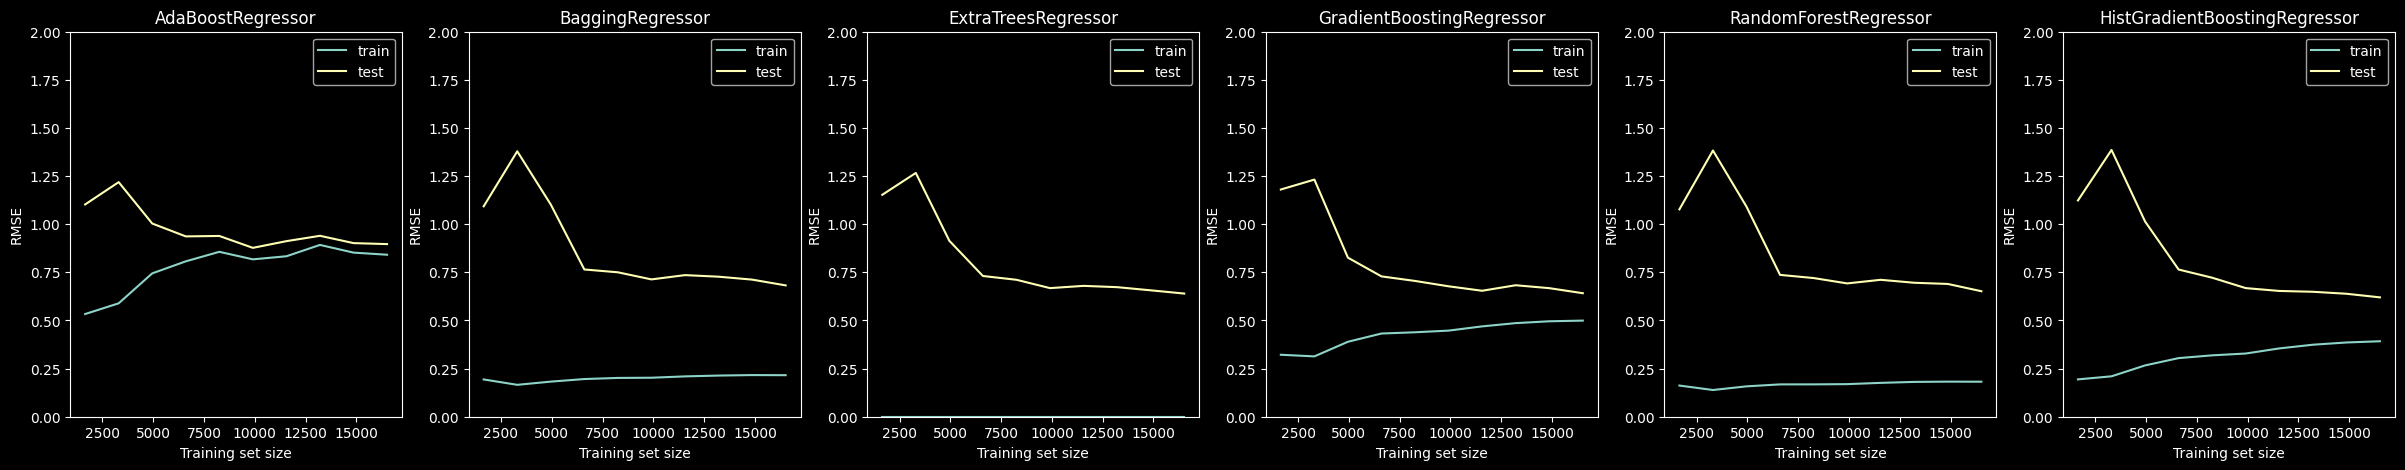

In [94]:
#Learning curves des modèles ensemblistes

def ens_learnings_curves(
    models,
    data,
    target
):
    plt.figure(1)
    fig, graphs = plt.subplots(1, len(models), figsize=(5* len(models), 5))
    n_jobs = -1
    points_amount = 10
    train_score_arr = []
    test_scores_arr = []

    for i in tqdm(range(len(models))):
        graphs[i].set_title(models[i].__class__.__name__)
        graphs[i].set_xlabel("Training set size")
        graphs[i].set_ylabel("RMSE")
        
        train_sizes, train_scores, test_scores = learning_curve(
        random_state=69,
        estimator = models[i],
        X=data,
        y=target,
        n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1, points_amount),
        scoring="neg_root_mean_squared_error"
        )

        train_scores_mean = -np.mean(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)

        train_score_arr.append(train_scores_mean)
        test_scores_arr.append(test_scores_mean)


    for i in range(len(train_score_arr)):
        graphs[i].set_ylim(0,2)
        graphs[i].plot(train_sizes, train_score_arr[i])
        graphs[i].plot(train_sizes, test_scores_arr[i])
        graphs[i].legend(labels=["train", "test"], loc="upper right")

    return plt

#Call de la fonction
ens_learnings_curves(
    ens_models,
    data,
    target
)

plt.show()

## III - Recherche des meilleurs hyperparamètres

##### Recherche des meilleurs hyperparamètres pour le HistGradientBoostingRegressor

In [95]:
#Fonction fit + score
def fit_and_score(alg):
    alg.fit(data_train, target_train)
    print("R2 : "+str(alg.score(data_test, target_test)*100))
    return alg.score(data_test, target_test)*100

In [96]:
#Modèle de base
model = HistGradientBoostingRegressor(
    random_state=69,
)

fit_and_score(model)

R2 : 82.88415603200865


82.88415603200865

In [97]:
#Recherche "max_iter"
model = HistGradientBoostingRegressor(
    random_state=69,
    min_samples_leaf=20,
    max_depth=12,
    learning_rate=0.1,
)

parameters = {
    'max_iter':range(10,501,10),
}

reg = GridSearchCV(estimator=model, param_grid=parameters)

reg.fit(data_train, target_train)
print(reg.best_params_)
print(reg.score(data_test, target_test)*100)

{'max_iter': 190}
83.84447277375038


In [98]:
#Recherche "min_samples_leaf" & "max_depth"
model = HistGradientBoostingRegressor(
    random_state=69,
    max_iter=280,
    learning_rate=0.1,
)

parameters = {
    'min_samples_leaf':range(10, 121, 10),
    'max_depth':range(10,21,2),
}

reg = GridSearchCV(estimator=model, param_grid=parameters)

reg.fit(data_train, target_train)
print(reg.best_params_)
print(reg.score(data_test, target_test)*100)

{'max_depth': 12, 'min_samples_leaf': 50}
83.44065284718931


In [99]:
#Final HistGradientBoostingRegressor parameters
model = HistGradientBoostingRegressor(
    random_state=69,
    max_depth=18,
    min_samples_leaf=40,
    max_iter=280,
    learning_rate=0.1,
    warm_start=True
)

fit_and_score(model)

r = np.absolute(model.predict(data) - target)*100

print(str(np.mean(r)) + " +- " + str(np.std(r)))

R2 : 84.06712515231472
24.0645280943564 +- 27.24598606765954


##### Recherche des meilleurs hyperparamètres pour le AdaBoostRegressor

In [100]:
#Modèle de base
m = AdaBoostRegressor(random_state=69, base_estimator=model)
fit_and_score(m)

R2 : 84.1828335511531


84.1828335511531

In [101]:
#Recherche "n_estimators" & "learning_rate"
m = AdaBoostRegressor(random_state=69,
                      base_estimator=model,
                      learning_rate=0.1)

parameters = {
    'n_estimators':range(40, 51, 5),
    'learning_rate':[0.1, 1],
}

reg = GridSearchCV(estimator=m, param_grid=parameters)

reg.fit(data_train, target_train)
print(reg.best_params_)
print(reg.score(data_test, target_test)*100)

{'learning_rate': 0.1, 'n_estimators': 40}
84.68460666975635


##### AdaBoostRegressor(HistGradientRegressor())

In [102]:
#Final Results Ada(Hist())
final_model = AdaBoostRegressor(random_state=69, learning_rate=1,n_estimators=115, base_estimator=HistGradientBoostingRegressor(learning_rate=0.1, max_iter=1000, max_depth=7, warm_start=True, max_leaf_nodes=60, random_state=69,  max_bins=255))

fit_and_score(final_model)

r = np.absolute(final_model.predict(data) - target)*100

print(str(np.mean(r)) + " +- " + str(np.std(r)))

R2 : 85.1542366577762
11.952681698961994 +- 17.70402581658711


## IV - Sauvegarde de l'IA

In [103]:
#Sauvegarde de l'IA

def AI_train_and_save(model):
    
    #Initialisation de la dataframe des resultats
    result_df = pd.DataFrame(columns=["ModelName","Score"])

    #Affichage
    model_name = model.__class__.__name__ + "(" +  model.base_estimator.__class__.__name__ + "())"

    #Fit
    model.fit(data_train, target_train)

    #Calcul du score
    score = model.score(data_test, target_test)*100

    #Sauvegarde des resultats dans la dataframe
    new_row = pd.DataFrame([[model_name, score]], columns=["ModelName","Score"])
    result_df = pd.concat([result_df, new_row])

    #Affichage du score
    print(result_df)

    #Sauvegarde de l'IA
    with open(f"{score}.joblib", "wb") as fo:
        joblib.dump(model, fo)

#Call de la fonction
AI_train_and_save(final_model)

                                           ModelName      Score
0  AdaBoostRegressor(HistGradientBoostingRegresso...  85.154237


## V - Test de l'IA

In [105]:
#Test

#Chargement de l'IA sauvegardée
with open("85.1542366577762.joblib", "rb") as fo:
    cf = joblib.load(fo)

#Predict
predicted = cf.predict(data)
d = {'Predicted': predicted, 'Original': target, 'Ecart': np.absolute(predicted-target)*100000}

#Stockage et affichage du resultat
supa_resulto_dataframu = pd.DataFrame(data=d)
print(supa_resulto_dataframu)

#Affichage des stats
print(np.min(supa_resulto_dataframu["Ecart"]))
print(np.average(supa_resulto_dataframu["Ecart"]))
print(np.median(supa_resulto_dataframu["Ecart"]))

       Predicted  Original          Ecart
0       4.432357     4.526    9364.269210
1       3.630886     3.585    4588.646308
2       4.582870     3.521  106187.002778
3       3.466137     3.413    5313.689268
4       3.315778     3.422   10622.246697
...          ...       ...            ...
20635   0.768587     0.781    1241.282860
20636   0.828364     0.771    5736.406130
20637   0.897097     0.923    2590.302024
20638   0.898776     0.847    5177.629022
20639   0.874969     0.894    1903.095152

[20640 rows x 3 columns]
0.5284826749663019
11952.681698961995
8594.969820317034
